# Exploration des données du problème et visualisation des erreurs de classification

In [1]:
import pandas as pd
import unicodedata
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from scipy.sparse import hstack
from sklearn.linear_model import RidgeClassifier, LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np


string_columns = ["model_label","commercial_label","article_main_category","article_type","article_detail","comment", "color_label",'size',"accurate_gender"]

def read_df(file):
    
    df = pd.read_csv(file,sep=',', dtype={'incorrect_fedas_code':str, 'correct_fedas_code':str, 'avalability_start_date':str, 
                                                                                      'avalability_end_date':str, 'shipping_date':str})
    df = df.fillna("")


    def fedas_category(fedas):
        if fedas=="":
            return ""
        else:
            return fedas[0]

    def fedas_activity_domain(fedas):
        if fedas=="":
            return ""
        else:
            return fedas[1:3]

    def fedas_principal_group(fedas):
        if fedas=="":
            return ""
        else:
            return fedas[3:5]

    def fedas_subgroup(fedas):
        if fedas=="":
            return ""
        else:
            return fedas[-1]

    df["incorrect_fedas_code_category"] = df["incorrect_fedas_code"].apply(fedas_category)
    df["incorrect_fedas_activity_domain"] = df["incorrect_fedas_code"].apply(fedas_activity_domain)
    df["incorrect_fedas_principal_group"] = df["incorrect_fedas_code"].apply(fedas_principal_group)
    df["incorrect_fedas_subgroup"] = df["incorrect_fedas_code"].apply(fedas_subgroup)
    
    if "correct_fedas_code" in df.columns:
        df["correct_fedas_code_category"] = df["correct_fedas_code"].apply(fedas_category)
        df["correct_fedas_activity_domain"] = df["correct_fedas_code"].apply(fedas_activity_domain)
        df["correct_fedas_principal_group"] = df["correct_fedas_code"].apply(fedas_principal_group)
        df["correct_fedas_subgroup"] = df["correct_fedas_code"].apply(fedas_subgroup)


    def clean(input_str):
        '''
        Clean an input str by removing unwanted characters and 

                Parameters:
                        input_str (str): The string to be cleaned

                Returns:
                        cleaned (str) : The string cleaned
        '''
        cleaned=input_str.lower().replace('/',' ').replace('-',' ')
        return cleaned



    for s in string_columns:
        df[s] = df[s].apply(clean)

    return df


df=read_df('C:/python_code/unifai/train_technical_test.csv')


def train_test_split_df(df,frac,random_state=-1):
    '''
    Split a dataframe in a train and test dataframes copies.

            Parameters:
                    df (DataFrame): The dataframe to be split
                    frac (float): The fraction of the data set aside in the test dataframe
                    random_state (int) : Optionnal positive integer parameter to set the seed for the random module

            Returns:
                    df_train, df_test tuple(DataFrame): tuple of train dataframe and test dataframe
    '''
    if random_state>0:
        random.seed(random_state)
    n_size=df.shape[0]
    inds = set(random.sample(list(range(n_size)), int(frac*n_size)))
    train_inds = [n for n in range(n_size) if n in inds]
    test_inds = [n for n in range(n_size) if n not in inds]
        
    df_train=df.iloc[train_inds].copy()
    df_test=df.iloc[test_inds].copy()
    return df_train, df_test

df_train, df_test=train_test_split_df(df,0.9,67286)

In [2]:
def vectorize_df_strings(df_train,df_test,string_columns):
    '''
    Take a train and a test dataframe and vectorize chosen string columns into a matrix.

            Parameters:
                    df_train (DataFrame): The train dataframe
                    df_test (DataFrame): The test dataframe
                    string_columns list(str) : The list of the columns to be vectorized. Must be both in df_train and df_test.

            Returns:
                    X_train, X_test,features_words tuple(matrix,matrix,array): tuple of matrix based on tf-idf decomposition for df_train and df_test 
                                                                and array of features names
    '''
    final_stopwords_list = stopwords.words('english') + stopwords.words('french')
    tf_idf_train_list=[]
    tf_idf_test_list=[]
    features_words=np.asarray([])
    
    for s in string_columns:
        vectorizer = TfidfVectorizer(max_df=1.0, min_df=1, stop_words=final_stopwords_list)        
        vectorized_column_train = vectorizer.fit_transform(df_train[s])
        features=s+":"+vectorizer.get_feature_names_out()
        features_words=np.concatenate((features_words, features), axis=None)
        tf_idf_train_list.append(vectorized_column_train)
        # Extracting features from the test data using the same vectorizer
        vectorized_column_test = vectorizer.transform(df_test[s])
        tf_idf_test_list.append(vectorized_column_test)
        
    X_train=hstack(tf_idf_train_list)
    X_test=hstack(tf_idf_test_list)
    return X_train, X_test,features_words

    
    

X_train,X_test,features_words=vectorize_df_strings(df_train,df_test,string_columns)




In [3]:
def get_model_and_metrics(X_train,X_test,y_train,y_test):
    '''
    Take the train and the test datasets for regression problem and return model and metrics based on LogisticRegression.

            Parameters:
                    X_train (matrix): The train matrix of features
                    X_test (matrix): The test matrix of features
                    y_train (Series) : The panda series to be predicted for train set
                    y_test (Series) : The panda series to be predicted for test set

            Returns:
                    train_score,test_score,predicted_train,predicted_test,clf tuple(float,float,list,list,model): train_score, test_score, and lists of predicted on train set and test set, and model
    '''
    clf=LogisticRegression(C=5, max_iter=1000)
    clf.fit(X_train,y_train)
    train_score=clf.score(X_train, y_train)
    test_score=clf.score(X_test, y_test)
    predicted_train=clf.predict(X_train).tolist()
    predicted_test=clf.predict(X_test).tolist()
    return train_score,test_score,predicted_train,predicted_test,clf


def confusion_matrix(to_predict,predicted,column):
    '''
    Plot the confusion matrix between to_predict and predicted, with the label set in column.
    '''
    fig, ax = plt.subplots(figsize=(10, 5))
    ConfusionMatrixDisplay.from_predictions(to_predict, predicted, ax=ax)
    _ = ax.set_title(
    "Confusion Matrix for {}".format(column)
    )
    plt.show()
    return


def confusion_matrix_subset(to_predict,predicted,column):
    '''
    Plot the confusion matrix between to_predict and predicted, with the label set in column.
    Categories are kept only if they lead to a confusion coefficient of more than 1%. 
    '''
    
    n_size=len(to_predict)
    df = pd.DataFrame(list(zip(to_predict, predicted)),columns =['to_predict', 'predicted'])
    categories=df['to_predict'].unique()
    n_cat=len(categories)
    #On calcule la matrice de confusion pour faire une selection des coefficients qui representent plus de 1% des erreurs.
    confusion_mat=np.zeros((n_cat, n_cat))
    for i in range(n_cat):
        predicted_cat=categories[i]
        for j in range(n_cat):
            to_predict_cat=categories[j]
            confusion_mat[i][j]=df.loc[(df["predicted"]==predicted_cat) & (df["to_predict"]==to_predict_cat)
                                       , "to_predict"].count()
    errors=confusion_mat.sum()-confusion_mat.trace()
    seuil=int(errors/100.0)
    
    #On ne garde que les categories qui correspondent a des indices de la matrice de confusion au dessus du seuil
    categories_to_keep=[]
    for i in range(n_cat):
        predicted_cat=categories[i]
        for j in range(n_cat):
            to_predict_cat=categories[j]
            if i!=j and confusion_mat[i][j]>seuil:#Si coefficient superieur au seuil ailleurs que sur la diagnolae
                categories_to_keep.append(predicted_cat)
                categories_to_keep.append(to_predict_cat)
                
    df_subset=df[(df["predicted"].isin(categories_to_keep) & df["to_predict"].isin(categories_to_keep))]
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ConfusionMatrixDisplay.from_predictions(df_subset["to_predict"], df_subset["predicted"], ax=ax)
    _ = ax.set_title(
    "Confusion Matrix SUBSET for {}".format(column)
    )
    plt.show()
    
    return

In [4]:
def plot_feature_effects(clf,X_train,feature_names,title,subset_targets):
    '''
    Print the top 5 keywords by class and plot the barchar of weight of most valued keywords for each class.
    
            Parameters:
                    clf (sklean.model): The trained model
                    X_train (matrix): The train matrix of features
                    feature_names array(str) : The array of names for features corresponding to X_train (equivalent to DF columns)
                    title (str) : Title of the plot
                    subset_targets list(str) : The list for subsetting the targets. If null, all targets are returned. 
    
    
    '''
    # learned coefficients weighted by frequency of appearance
    average_feature_effects = clf.coef_ * np.asarray(X_train.mean(axis=0)).ravel()
    
    if subset_targets is None:
        target_names=clf.classes_
    else:
        target_names=subset_targets
    df_created=False
    for i, label in enumerate(clf.classes_):
        if (subset_targets is None) or (label in subset_targets):
            top5 = np.argsort(average_feature_effects[i])[-5:][::-1]
            if not df_created:
                top = pd.DataFrame(feature_names[top5], columns=[label])
                top_indices = top5
                df_created=True
            else:
                top[label] = feature_names[top5]
                top_indices = np.concatenate((top_indices, top5), axis=None)
    top_indices = np.unique(top_indices)
    predictive_words = feature_names[top_indices]

    # plot feature effects
    bar_size = 0.25
    padding = 0.75
    y_locs = np.arange(len(top_indices)) * (4 * bar_size + padding)

    fig, ax = plt.subplots(figsize=(10, 8))
    for i, label in enumerate(clf.classes_):
        if (subset_targets is None) or (label in subset_targets):
            ax.barh(
                y_locs + (i - 2) * bar_size,
                average_feature_effects[i, top_indices],
                height=bar_size,
                label=label,
            )
    ax.set(
        yticks=y_locs,
        yticklabels=predictive_words,
        ylim=[
            0 - 4 * bar_size,
            len(top_indices) * (4 * bar_size + padding) - 4 * bar_size,
        ],
    )
    ax.legend(loc="lower right")
    ax.set_title(title)

    print("top 5 keywords per class:")
    print(top)
    plt.show()

    return


Train score et test score pour la colonne correct_fedas_code_category : 0.9997456836870214 et 0.9946605644546148. 


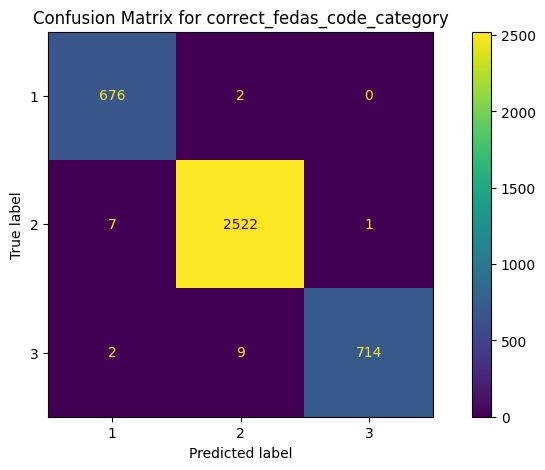

Train score et test score pour la colonne correct_fedas_activity_domain : 0.9958461668880161 et 0.9303330790744978. 


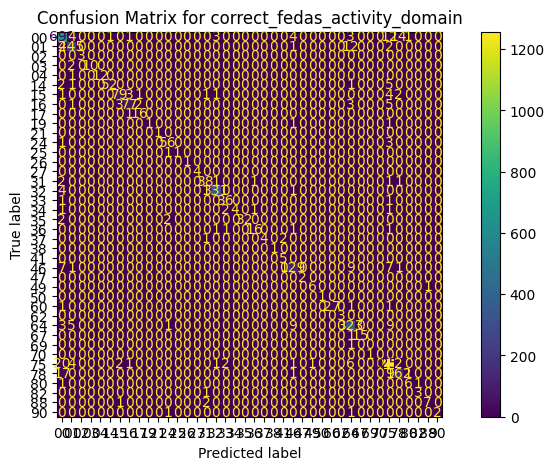

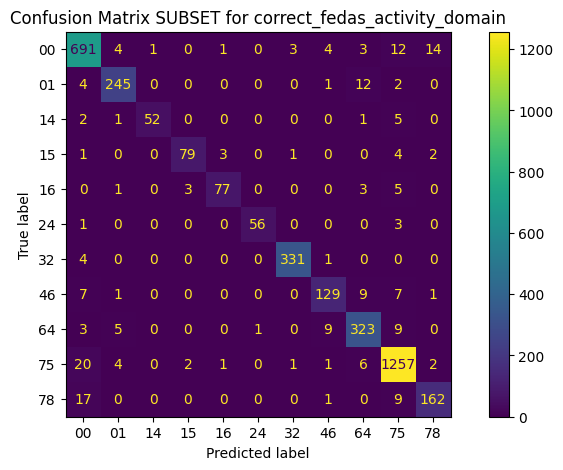

In [ ]:
models={}
predicted_columns=[]
for to_predict in ["correct_fedas_code_category","correct_fedas_activity_domain","correct_fedas_principal_group","correct_fedas_subgroup"]:
    train_score,test_score,predicted_train,predicted_test,model=get_model_and_metrics(X_train,X_test,df_train[to_predict],df_test[to_predict])
    print('Train score et test score pour la colonne {} : {} et {}. '.format(to_predict, train_score, test_score))
    models[to_predict]=model
    
    #Impression des matrices de confusion
    confusion_matrix(df_test[to_predict],predicted_test,to_predict)
    if len(df_test[to_predict].unique())>10:
        confusion_matrix_subset(df_test[to_predict],predicted_test,to_predict)
    predicted_columns.append(predicted_test)
    
    #Detection des plus grosses features pour correct_fedas_subgroup
    if to_predict=="correct_fedas_subgroup":
        plot_feature_effects(model,X_train,features_words,'Analyse des features pour fedas subgroup',None)

#Reconstitution de la colonne predite pour le fedas code entier
predicted_fedas_code=[x1+x2+x3+x4 for x1,x2,x3,x4 in zip(predicted_columns[0],predicted_columns[1],predicted_columns[2],predicted_columns[3])]   
df_test['predicted_fedas_code']=predicted_fedas_code

#Calcul de la precision sur le test set (test set genere aleatoirement en debut de code pour estimation de l'erreur de generalisation)
df_test['correctly_predicted']=df_test['predicted_fedas_code']==df_test['correct_fedas_code']
ratio=df_test["correctly_predicted"].sum()/df_test.shape[0]
print("Accuraty on test set : {}".format(ratio))


In [ ]:
#Construction du modele final
def predict_with_confidence(df,X):
    predicted_columns=[]
    confidence_list=[]
    for to_predict in ["correct_fedas_code_category","correct_fedas_activity_domain","correct_fedas_principal_group","correct_fedas_subgroup"]:
        clf=models[to_predict]
        predicted=clf.predict(X).tolist()
        confidence=np.amax(clf.predict_proba(X), axis=1).tolist()
        
        predicted_columns.append(predicted)
        confidence_list.append(confidence)
    
    predicted_fedas_code=[x1+x2+x3+x4 for x1,x2,x3,x4 in zip(predicted_columns[0],predicted_columns[1],predicted_columns[2],predicted_columns[3])]
    confidence_fedas=[x1*x2*x3*x4 for x1,x2,x3,x4 in zip(confidence_list[0],confidence_list[1],confidence_list[2],confidence_list[3])]
    
    df['predicted_fedas_code']=predicted_fedas_code
    df['confidence_fedas']=confidence_fedas
    return

df_test_unifai=read_df('C:/python_code/unifai/test_technical_test.csv')
X_train,X_test_unifai,features_words=vectorize_df_strings(df_train,df_test_unifai,string_columns)

predict_with_confidence(df_test_unifai,X_test_unifai)

df_test_unifai.to_csv("C:/python_code/unifai/train_technical_test_predicted.csv",index=False)  